# Non-cooperative autonomous algorithmic collusion: Q-learning under sequential Hotelling's model

Jeonghan Seo <br/>
Faculty of Economics and Business, University of Amsterdam

The following Python code generates the results presented in the bachelor thesis titled "Non-cooperative autonomous algorithmic collusion: Q-learning under sequential Hotelling's model"

I conducted simulations with several combinations of parameters and saved the result files in folders named as the following format.  <br/>
"epsilon start_epsilon decay_epsilon min_alpha_delta_nprices_nlocations_len episodes_num episodes_memory length"<br/>
where <br/>
epsilon start = Initial value of $\varepsilon_t$  <br/>
epsilon decay = Decaying rate of $\varepsilon_t$  <br/>
epsilon min = Minimum value of $\varepsilon_t$  <br/>
alpha = Learning rate  <br/>
delta = Discount factor  <br/>
nprices = Number of prices  <br/>
nlocations = Number of locations  <br/>
len episodes = Length of each episode (time steps)  <br/>
num episodes = Number of episodes  <br/>
memory length = Memory length  <br/>

In [2]:
import os
import numpy as np
import pandas as pd
import random
import copy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from collections import defaultdict
from collections import deque
from tqdm import tqdm
from tabulate import tabulate
from itertools import islice
from statsmodels.tsa.stattools import adfuller

In [3]:
# define demand funtion of prices and locations
def demand(own_price, own_location, other_price, other_location, actions_locations):
    dem = 0
    for l in actions_locations:
        if own_price + abs(own_location - l) < other_price + abs(other_location - l):
            dem += 2
        elif own_price + abs(own_location - l) == other_price + abs(other_location - l):
            dem += 1
        else:
            dem += 0
    return(dem)

# define a reward function
def reward(own_price, own_location, other_price, other_location, actions_locations):
    return own_price * demand(own_price, own_location, other_price, other_location, actions_locations)

# define a funtion that create cartesian product of sets
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

# define a funtion that find a number(index) of actions
def find_action_number(actions, price, location ):
    return( int( np.where( (actions[:, 0] == price) & (actions[:, 1] == location))[0][0] ))

# define a funtion that create moving average with a period parameter of N
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Sequential Q-learning

In [7]:
def Qlearn(epsilon_start, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length):
    
    epsilon = epsilon_start
    
    # initialize Q-tables
    Q0 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q1 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q = [Q0, Q1]
    
    # lists for saving history of profit
    pro0 = [0] * len_episodes
    pro1 = [0] * len_episodes
    pro = [pro0, pro1]
    
    # initialize the action/state set
    actions_prices= 1 / nprices*np.linspace(0, nprices, nprices)
    actions_locations= 1 / nlocations*np.linspace(0, nlocations, nlocations)
    actions = cartesian_product(actions_prices, actions_locations)

    for n in range(num_episodes): # simulate n epsiodes
        
        # itialize history with randomly chosen prices and locations
        #random.seed(2023)
        history = [deque(actions[random.sample(range(nprices*nlocations), 2)], maxlen=memory_length) for i in range(2)]
        for t in tqdm(range(2, len_episodes)): # iterate through time-steps within an episode
            
            if t % 2 == 0:
                act_agent = 0; inact_agent = 1
            else:
                act_agent = 1; inact_agent = 0
                
            # action number of act_agent at t-2
            a_act_2_number = find_action_number(actions, history[act_agent][-2][0], history[act_agent][-2][1])
            # action number of inact_agent at t-2
            a_inact_2_number = find_action_number(actions, history[inact_agent][-2][0], history[inact_agent][-2][1])
            # action number of inact_agent at t-1
            a_inact_1_number = find_action_number(actions, history[inact_agent][-1][0], history[inact_agent][-1][1])
            
            # profit of act_agent at t-2
            profit2=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-2][0], history[inact_agent][-2][1], actions_locations)
            # profit of act_agent at t-1
            profit1=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            
            # update Q-tables
            Q[act_agent][a_act_2_number][a_inact_2_number] = (1-alpha)*(Q[act_agent][a_act_2_number][a_inact_2_number]) + alpha*(profit2 + delta*profit1 + (delta**2)* np.max(Q[act_agent][:, a_inact_1_number]))
            
            # choose epsilon greedy action
            #np.random.seed(t)
            if np.random.rand()<=epsilon:
                history[act_agent].append(actions[random.randrange(nprices*nlocations)])
            else:
                history[act_agent].append(actions[np.argmax(Q[act_agent][:, a_inact_1_number])])
            history[inact_agent].append(history[inact_agent][-1])
            
            # saving profits
            pro[act_agent][t]=reward(history[act_agent][-1][0], history[act_agent][-1][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            pro[inact_agent][t]=reward(history[inact_agent][-1][0], history[inact_agent][-1][1], history[act_agent][-1][0], history[act_agent][-1][1], actions_locations)
            
            # decay epsilon 
            if t % 2 == 1 and epsilon>epsilon_min:
                epsilon*= epsilon_decay
        
        # save the results
        now = datetime.now()
        file_name=now.strftime("%Y_%m_%d_%H_%M") + "_" + str(epsilon_start) + "_" + str(epsilon_decay) + "_" + str( epsilon_min) + "_" + str(alpha) + "_" + str(delta) + "_" + str(nprices) + "_" + str(nlocations) + "_" + str(len_episodes) + "_" + str(num_episodes) + "_" + str(memory_length)
        with open(file_name, 'wb') as f:
            pickle.dump([Q, history, pro], f)
    return Q, history, pro

# Simulations

### Baseline simulation

In [ ]:
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.01
alpha = 0.3
delta = 0.95
nprices = 5
nlocations = 6
len_episodes = 2000000
num_episodes = 1
memory_length = 2000000
for i in range(100):
    Qlearn(epsilon, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length)
    print(f"{i}th simulation complete.")

### Simulation with $\delta=0.4$

In [ ]:
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.01
alpha = 0.3
delta = 0.4
nprices = 5
nlocations = 6
len_episodes = 2000000
num_episodes = 1
memory_length = 2000000
for i in range(100):
    Qlearn(epsilon, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length)
    print(f"{i}th simulation complete.")

# Profitability

In [42]:
# load file list of simulations data
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

profitability0 = np.zeros(1995001)
profitability1 = np.zeros(1995001)

# load each pickle file of simulation data in the list
for file_name in  tqdm(file_list[0:100]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        profitability0 = profitability0 + running_mean(data[2][0], 5000)
        profitability1 = profitability1 + running_mean(data[2][1], 5000)

# Average of 100 simulations
profitability0 = profitability0 / 100
profitability1 = profitability1 / 100

with open("profitability", 'wb') as f:
    pickle.dump([profitability0, profitability1], f)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:45<00:00,  4.05s/it]


### Profitability: line graph for two firms

<ipython-input-9-cebc6faf3cef>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


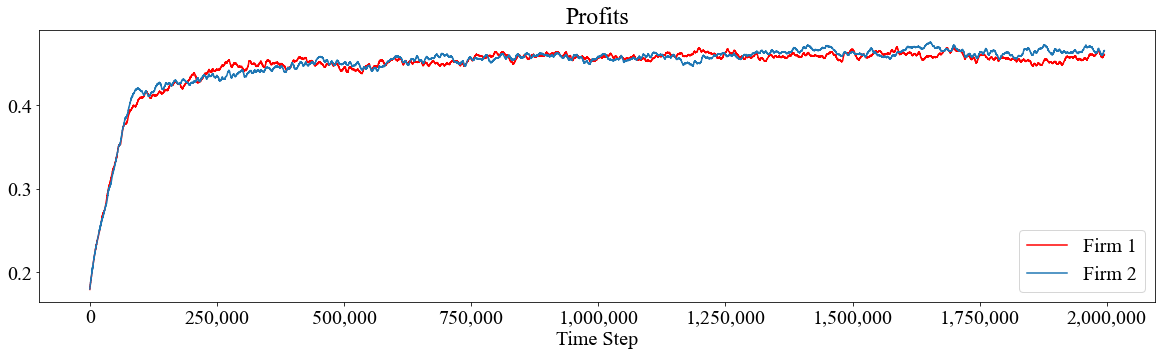

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(profitability0)), profitability0/12,'r') # profitability is normalized to the joint-profit maximizing
plt.plot(range(len(profitability1)), profitability1/12) # profitability is normalized to the joint-profit maximizing
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.title('Profits')
plt.legend(('Firm 1','Firm 2'))

### Joint profits: line graph

<ipython-input-10-1112d8dc2ec4>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


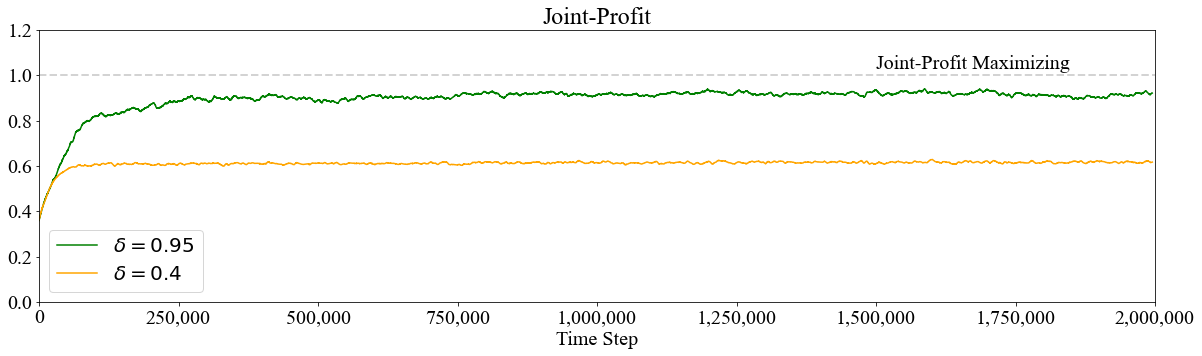

In [10]:
# load profitability of baseline
with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\profitability\\profitability", 'rb') as f1:
        profitability_baseline = pickle.load(f1)
# load profitability with delta=0.4    
with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.4_5_6_2000000_1_2000000\\profitability\\profitability", 'rb') as f2:
        profitability_lower_delta = pickle.load(f2)
    
    
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(profitability_baseline[0])), (profitability_baseline[0] + profitability_baseline[0])/12,'g')
plt.plot(range(len(profitability_lower_delta[0])), (profitability_lower_delta[0] + profitability_lower_delta[1])/12,'orange')
plt.xlim((0, 2000000))
plt.ylim((0, 1.2))
plt.axhline(1.0, color='lightgray', linestyle='--', linewidth=2)
plt.text(1500000, 1.03, 'Joint-Profit Maximizing')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Joint-Profit')
plt.legend(('$\delta=0.95$','$\delta=0.4$'))

### Joint profits: joint distribution

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:01<00:00,  4.21s/it]


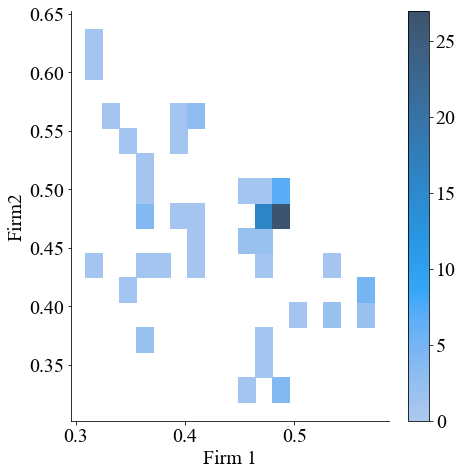

In [11]:
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")
profitability0_list = []
profitability1_list = []
for file_name in  tqdm(file_list[0:100]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        profitability0_list.append(running_mean(data[2][0], 5000)[-1]/12)
        profitability1_list.append(running_mean(data[2][1], 5000)[-1]/12)
        
df_profitability = pd.DataFrame({'Firm 1': profitability0_list, 'Firm2': profitability1_list})
sns.displot(df_profitability, x="Firm 1", y="Firm2", cbar=True, height=7, aspect=1)

# Price

In [12]:
# load file list of simulations data
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

price0 = np.zeros(1995001)
price1 = np.zeros(1995001)

# load each pickle file of simulation data in the list
for file_name in  tqdm(file_list[0:100]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        price0 = price0 + np.array(running_mean([arr[0] for arr in data[1][0]], 5000))
        price1 = price1 + np.array(running_mean([arr[0] for arr in data[1][1]], 5000))

# Average of 100 simulations
price0 = price0 / 100
price1 = price1 / 100

with open("price", 'wb') as f:
    pickle.dump([price0, price1], f)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:15<00:00,  4.36s/it]


### Price: line graph for two firms

<ipython-input-13-5cfe5ccb6b58>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


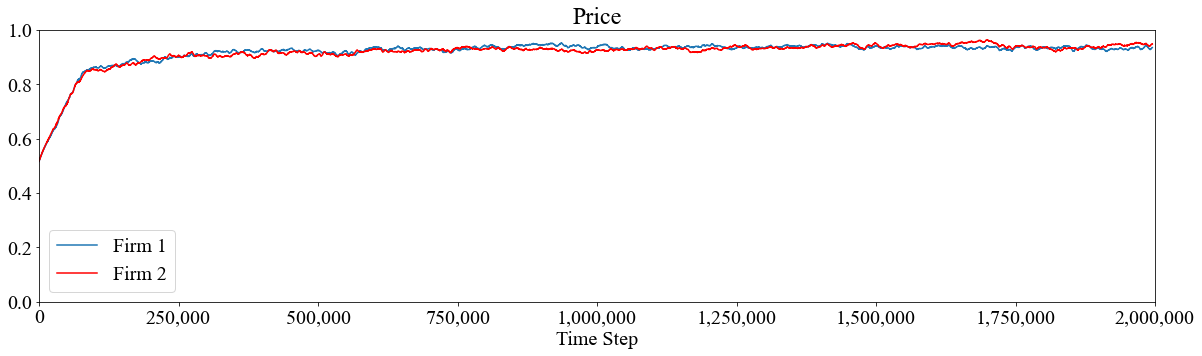

In [13]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(price0)), price0)
plt.plot(range(len(price1)), price1, 'r')
plt.xlim((0, 2000000))
plt.ylim((0, 1))
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Price')
plt.legend(('Firm 1','Firm 2'))

### Price: line graph of five simulations for firm 1

In [15]:
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

history_price = []
for file_name in  tqdm(file_list[0:5]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        history_price.append([arr[0] for arr in data[1][0]])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it]


<ipython-input-16-824b3eb5e4c2>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Price')

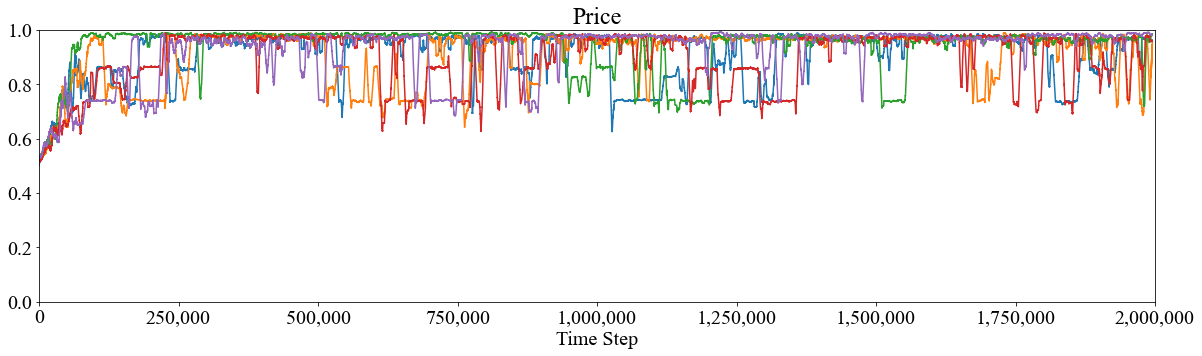

In [16]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.plot(range(len(running_mean(history_price[i], 5000))), running_mean(history_price[i], 5000), color=colors[i])
plt.xlim((0, 2000000))
plt.ylim((0, 1))
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Price')

# Location

In [4]:
# load file list of simulations data
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

history_location_agent0=[]
history_location_agent1=[]

# load a pickle file of one simulation
for file_name in  tqdm(file_list[12:13]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
    # append the history
    history_location_agent0.append([arr[1] for arr in data[1][0]])
    history_location_agent1.append([arr[1] for arr in data[1][1]])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


### Location: line graph for two firms from one simulation

<ipython-input-5-c1fbc16b62f4>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


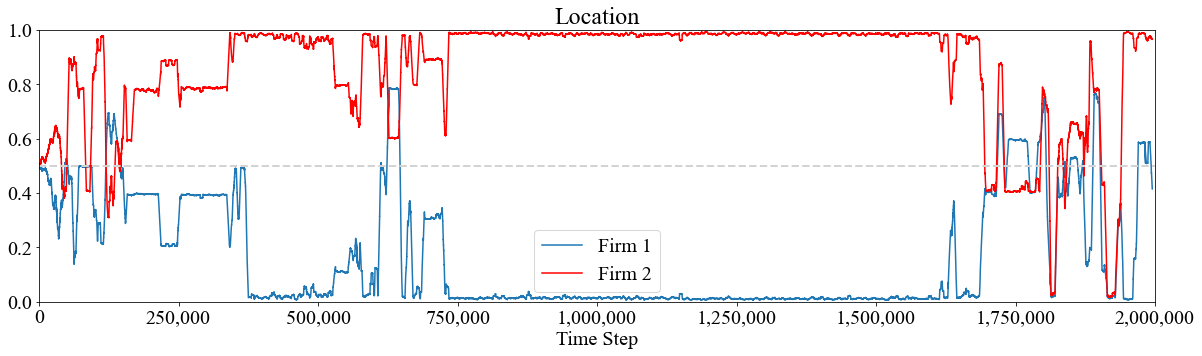

In [5]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(running_mean(history_location_agent0, 5000))), running_mean(history_location_agent0, 5000), )
plt.plot(range(len(running_mean(history_location_agent1, 5000))), running_mean(history_location_agent1, 5000), 'r')
plt.xlim((0, 2000000))
plt.ylim((0, 1))
plt.axhline(0.5, color='lightgray', linestyle='--', linewidth=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Location')
plt.legend(('Firm 1','Firm 2'))

### Location: line graph for two firms from t=1,750,000 to t=1,950,000 from one simulation

<ipython-input-6-1a91f0358c62>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


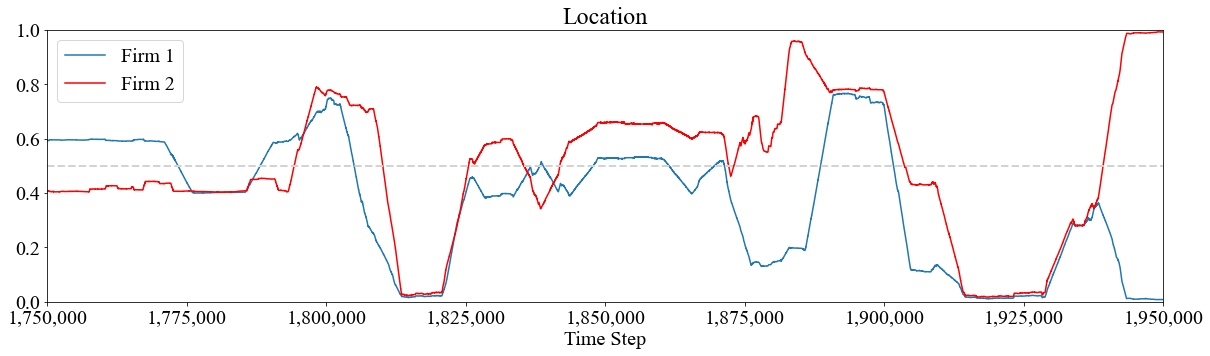

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(running_mean(history_location_agent0, 5000))), running_mean(history_location_agent0, 5000), )
plt.plot(range(len(running_mean(history_location_agent1, 5000))), running_mean(history_location_agent1, 5000), 'r')
plt.xlim((1750000, 1950000))
plt.ylim((0, 1))
plt.axhline(0.5, color='lightgray', linestyle='--', linewidth=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Location')
plt.legend(('Firm 1','Firm 2'))

### Location: define $d_t = |l_{1,t} - 0.5| - |l_{2,t} - 0.5|$

In [20]:
# load file list of simulations data
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

# load a pickle file of one simulation
for file_name in  tqdm(file_list[0:1]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]


In [21]:
# calculate d_t = |l_{1,t} - 0.5| - |l_{2,t} - 0.5| from one simulation
d = [0 for _ in range(2000000)]
for t in range(1990000, 2000000):
    d[t]=( ( abs(data[1][0][t][1] - 0.5) ) - ( abs(data[1][1][t][1] - 0.5) ) )

### Location: line graph of $d_t$ from one simulation from t=1,990,000 to t=2,000,000

<ipython-input-22-e32922769d58>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, '$d_t$')

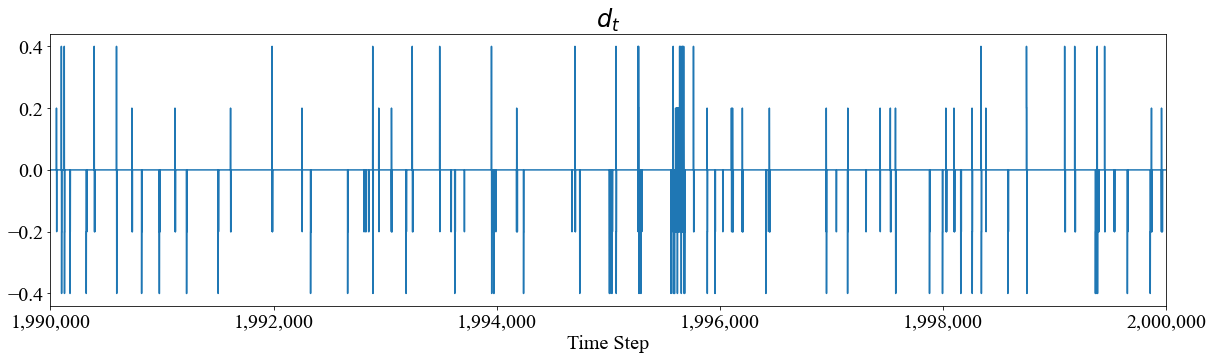

In [22]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(d)), d)
plt.xlim((1990000, 2000000))
plt.xlabel('Time Step')
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.title("$d_t$")

### Location: Augmented Dickey Fuller test

In [23]:
# define a function that print results of ADF test
def adf_test(y):
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [24]:
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

# perfrom Augmented Dickey Fuller test for 100 simulations
for file_name in  tqdm(file_list[0:100]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        location_difference = []
        for t in range(1990000, 2000000):
            location_difference.append( ( abs(data[1][0][t][1] - 0.5) ) - ( abs(data[1][1][t][1] - 0.5) ) )
        adf_test(location_difference)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Results of Augmented Dickey-Fuller test:


  1%|▊                                                                                 | 1/100 [00:04<06:45,  4.10s/it]

test statistic         -1.745130e+01
p-value                 4.651164e-30
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  2%|█▋                                                                                | 2/100 [00:08<06:49,  4.18s/it]

test statistic            -4.365572
p-value                    0.000341
# of lags                 36.000000
# of observations       9963.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


  3%|██▍                                                                               | 3/100 [00:12<06:38,  4.11s/it]

test statistic         -1.575901e+01
p-value                 1.197974e-28
# of lags               2.500000e+01
# of observations       9.974000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  4%|███▎                                                                              | 4/100 [00:16<06:30,  4.07s/it]

test statistic         -6.630342e+00
p-value                 5.736138e-09
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  5%|████                                                                              | 5/100 [00:20<06:27,  4.08s/it]

test statistic         -1.670364e+01
p-value                 1.454178e-29
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  6%|████▉                                                                             | 6/100 [00:24<06:20,  4.05s/it]

test statistic         -1.118710e+01
p-value                 2.419747e-20
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  7%|█████▋                                                                            | 7/100 [00:28<06:13,  4.02s/it]

test statistic         -9.355591e+00
p-value                 8.075942e-16
# of lags               3.200000e+01
# of observations       9.967000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


  8%|██████▌                                                                           | 8/100 [00:32<06:16,  4.09s/it]

test statistic            -3.878468
p-value                    0.002199
# of lags                 34.000000
# of observations       9965.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


  9%|███████▍                                                                          | 9/100 [00:36<06:13,  4.11s/it]

test statistic         -6.585943e+00
p-value                 7.314596e-09
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 10%|████████                                                                         | 10/100 [00:40<06:12,  4.14s/it]

test statistic         -1.458827e+01
p-value                 4.356215e-27
# of lags               3.500000e+01
# of observations       9.964000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 11%|████████▉                                                                        | 11/100 [00:45<06:18,  4.25s/it]

test statistic         -1.473270e+01
p-value                 2.644518e-27
# of lags               3.700000e+01
# of observations       9.962000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 12%|█████████▋                                                                       | 12/100 [00:49<06:14,  4.26s/it]

test statistic         -5.988235e+00
p-value                 1.770994e-07
# of lags               3.200000e+01
# of observations       9.967000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 13%|██████████▌                                                                      | 13/100 [00:53<06:05,  4.20s/it]

test statistic         -1.141608e+01
p-value                 7.057156e-21
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 14%|███████████▎                                                                     | 14/100 [00:58<06:07,  4.28s/it]

test statistic         -7.250533e+00
p-value                 1.784973e-10
# of lags               3.800000e+01
# of observations       9.961000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 15%|████████████▏                                                                    | 15/100 [01:02<06:04,  4.29s/it]

test statistic         -5.896190e+00
p-value                 2.847771e-07
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 16%|████████████▉                                                                    | 16/100 [01:06<05:57,  4.26s/it]

test statistic            -2.671806
p-value                    0.079045
# of lags                 32.000000
# of observations       9967.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 17%|█████████████▊                                                                   | 17/100 [01:10<05:46,  4.18s/it]

test statistic           -20.238538
p-value                    0.000000
# of lags                 23.000000
# of observations       9976.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 18%|██████████████▌                                                                  | 18/100 [01:14<05:40,  4.15s/it]

test statistic         -1.587642e+01
p-value                 8.860050e-29
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 19%|███████████████▍                                                                 | 19/100 [01:19<05:40,  4.21s/it]

test statistic         -1.493965e+01
p-value                 1.328455e-27
# of lags               3.300000e+01
# of observations       9.966000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 20%|████████████████▏                                                                | 20/100 [01:23<05:34,  4.18s/it]

test statistic         -7.248688e+00
p-value                 1.803821e-10
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 21%|█████████████████                                                                | 21/100 [01:27<05:28,  4.16s/it]

test statistic         -1.509249e+01
p-value                 8.155473e-28
# of lags               2.200000e+01
# of observations       9.977000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 22%|█████████████████▊                                                               | 22/100 [01:31<05:20,  4.10s/it]

test statistic         -1.463276e+01
p-value                 3.729269e-27
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 23%|██████████████████▋                                                              | 23/100 [01:35<05:13,  4.08s/it]

test statistic         -1.712219e+01
p-value                 7.243838e-30
# of lags               3.300000e+01
# of observations       9.966000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 24%|███████████████████▍                                                             | 24/100 [01:39<05:08,  4.06s/it]

test statistic         -8.576758e+00
p-value                 7.924822e-14
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 25%|████████████████████▎                                                            | 25/100 [01:43<05:04,  4.06s/it]

test statistic         -1.468013e+01
p-value                 3.165695e-27
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 26%|█████████████████████                                                            | 26/100 [01:47<04:59,  4.05s/it]

test statistic         -1.548762e+01
p-value                 2.508843e-28
# of lags               2.700000e+01
# of observations       9.972000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 27%|█████████████████████▊                                                           | 27/100 [01:51<04:54,  4.03s/it]

test statistic           -18.898941
p-value                    0.000000
# of lags                 26.000000
# of observations       9973.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 28%|██████████████████████▋                                                          | 28/100 [01:55<04:49,  4.03s/it]

test statistic           -19.629229
p-value                    0.000000
# of lags                 29.000000
# of observations       9970.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 29%|███████████████████████▍                                                         | 29/100 [01:59<04:44,  4.01s/it]

test statistic            -2.713554
p-value                    0.071722
# of lags                 36.000000
# of observations       9963.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 30%|████████████████████████▎                                                        | 30/100 [02:03<04:40,  4.00s/it]

test statistic         -7.573863e+00
p-value                 2.794955e-11
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 31%|█████████████████████████                                                        | 31/100 [02:07<04:37,  4.02s/it]

test statistic         -1.855141e+01
p-value                 2.092238e-30
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 32%|█████████████████████████▉                                                       | 32/100 [02:11<04:33,  4.03s/it]

test statistic         -1.630849e+01
p-value                 3.213616e-29
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 33%|██████████████████████████▋                                                      | 33/100 [02:15<04:30,  4.04s/it]

test statistic         -1.805625e+01
p-value                 2.630110e-30
# of lags               3.100000e+01
# of observations       9.968000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 34%|███████████████████████████▌                                                     | 34/100 [02:19<04:26,  4.04s/it]

test statistic         -1.461567e+01
p-value                 3.957935e-27
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 35%|████████████████████████████▎                                                    | 35/100 [02:23<04:22,  4.04s/it]

test statistic         -9.431987e+00
p-value                 5.160582e-16
# of lags               3.800000e+01
# of observations       9.961000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 36%|█████████████████████████████▏                                                   | 36/100 [02:27<04:17,  4.02s/it]

test statistic           -19.264402
p-value                    0.000000
# of lags                 22.000000
# of observations       9977.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 37%|█████████████████████████████▉                                                   | 37/100 [02:31<04:13,  4.02s/it]

test statistic         -1.869889e+01
p-value                 2.037431e-30
# of lags               2.400000e+01
# of observations       9.975000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 38%|██████████████████████████████▊                                                  | 38/100 [02:35<04:09,  4.03s/it]

test statistic         -9.299433e+00
p-value                 1.122872e-15
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 39%|███████████████████████████████▌                                                 | 39/100 [02:39<04:05,  4.03s/it]

test statistic         -1.074617e+01
p-value                 2.738326e-19
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 40%|████████████████████████████████▍                                                | 40/100 [02:44<04:05,  4.09s/it]

test statistic           -22.907807
p-value                    0.000000
# of lags                 20.000000
# of observations       9979.000000
Critical Value (1%)       -3.431005
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 41%|█████████████████████████████████▏                                               | 41/100 [02:48<04:04,  4.15s/it]

test statistic            -2.840636
p-value                    0.052700
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 42%|██████████████████████████████████                                               | 42/100 [02:52<03:58,  4.12s/it]

test statistic         -1.296625e+01
p-value                 3.149009e-24
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 43%|██████████████████████████████████▊                                              | 43/100 [02:56<03:52,  4.08s/it]

test statistic         -1.817468e+01
p-value                 2.441846e-30
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 44%|███████████████████████████████████▋                                             | 44/100 [03:00<03:47,  4.06s/it]

test statistic         -1.343985e+01
p-value                 3.864542e-25
# of lags               3.500000e+01
# of observations       9.964000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 45%|████████████████████████████████████▍                                            | 45/100 [03:04<03:42,  4.04s/it]

test statistic         -1.089725e+01
p-value                 1.183612e-19
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 46%|█████████████████████████████████████▎                                           | 46/100 [03:08<03:37,  4.03s/it]

test statistic         -1.580111e+01
p-value                 1.073795e-28
# of lags               3.800000e+01
# of observations       9.961000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 47%|██████████████████████████████████████                                           | 47/100 [03:12<03:33,  4.03s/it]

test statistic         -1.716488e+01
p-value                 6.803486e-30
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 48%|██████████████████████████████████████▉                                          | 48/100 [03:16<03:30,  4.04s/it]

test statistic         -1.802036e+01
p-value                 2.696514e-30
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 49%|███████████████████████████████████████▋                                         | 49/100 [03:20<03:25,  4.04s/it]

test statistic         -1.355601e+01
p-value                 2.359230e-25
# of lags               2.700000e+01
# of observations       9.972000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 50%|████████████████████████████████████████▌                                        | 50/100 [03:24<03:21,  4.03s/it]

test statistic         -1.732449e+01
p-value                 5.456481e-30
# of lags               2.300000e+01
# of observations       9.976000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:28<03:16,  4.02s/it]

test statistic         -1.638499e+01
p-value                 2.728545e-29
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 52%|██████████████████████████████████████████                                       | 52/100 [03:32<03:12,  4.01s/it]

test statistic         -1.748856e+01
p-value                 4.449681e-30
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:36<03:09,  4.03s/it]

test statistic         -1.745052e+01
p-value                 4.655509e-30
# of lags               3.300000e+01
# of observations       9.966000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:41<03:22,  4.40s/it]

test statistic            -3.414245
p-value                    0.010483
# of lags                 34.000000
# of observations       9965.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:46<03:14,  4.32s/it]

test statistic         -1.647071e+01
p-value                 2.284538e-29
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:50<03:06,  4.23s/it]

test statistic         -1.451988e+01
p-value                 5.546719e-27
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:54<02:59,  4.17s/it]

test statistic           -19.188740
p-value                    0.000000
# of lags                 27.000000
# of observations       9972.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:58<02:53,  4.13s/it]

test statistic         -1.636328e+01
p-value                 2.856825e-29
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 59%|███████████████████████████████████████████████▊                                 | 59/100 [04:02<02:48,  4.11s/it]

test statistic         -1.479648e+01
p-value                 2.131693e-27
# of lags               3.800000e+01
# of observations       9.961000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 60%|████████████████████████████████████████████████▌                                | 60/100 [04:06<02:43,  4.08s/it]

test statistic            -3.807422
p-value                    0.002832
# of lags                 26.000000
# of observations       9973.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 61%|█████████████████████████████████████████████████▍                               | 61/100 [04:10<02:38,  4.07s/it]

test statistic           -20.846266
p-value                    0.000000
# of lags                 25.000000
# of observations       9974.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 62%|██████████████████████████████████████████████████▏                              | 62/100 [04:14<02:33,  4.05s/it]

test statistic           -19.593231
p-value                    0.000000
# of lags                 27.000000
# of observations       9972.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 63%|███████████████████████████████████████████████████                              | 63/100 [04:18<02:30,  4.08s/it]

test statistic         -1.698379e+01
p-value                 8.972318e-30
# of lags               2.900000e+01
# of observations       9.970000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:22<02:26,  4.06s/it]

test statistic         -1.733290e+01
p-value                 5.396701e-30
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:26<02:21,  4.04s/it]

test statistic            -2.674875
p-value                    0.078488
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:30<02:16,  4.02s/it]

test statistic         -1.617822e+01
p-value                 4.293663e-29
# of lags               2.200000e+01
# of observations       9.977000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:34<02:12,  4.01s/it]

test statistic         -1.664974e+01
p-value                 1.607897e-29
# of lags               2.800000e+01
# of observations       9.971000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:38<02:08,  4.01s/it]

test statistic         -1.041431e+01
p-value                 1.770697e-18
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:42<02:05,  4.05s/it]

test statistic         -1.346020e+01
p-value                 3.542246e-25
# of lags               3.800000e+01
# of observations       9.961000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:46<02:03,  4.11s/it]

test statistic           -19.930211
p-value                    0.000000
# of lags                 26.000000
# of observations       9973.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:50<01:59,  4.11s/it]

test statistic            -5.228658
p-value                    0.000008
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:54<01:54,  4.10s/it]

test statistic            -3.986226
p-value                    0.001484
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:58<01:49,  4.07s/it]

test statistic           -19.432778
p-value                    0.000000
# of lags                 27.000000
# of observations       9972.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [05:02<01:45,  4.06s/it]

test statistic         -1.792632e+01
p-value                 2.893935e-30
# of lags               2.300000e+01
# of observations       9.976000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [05:07<01:42,  4.09s/it]

test statistic         -1.744190e+01
p-value                 4.704312e-30
# of lags               2.400000e+01
# of observations       9.975000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [05:12<01:44,  4.36s/it]

test statistic            -4.034597
p-value                    0.001240
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [05:17<01:45,  4.60s/it]

test statistic         -1.142184e+01
p-value                 6.843526e-21
# of lags               3.600000e+01
# of observations       9.963000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [05:22<01:43,  4.71s/it]

test statistic         -9.808086e+00
p-value                 5.754030e-17
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [05:27<01:39,  4.73s/it]

test statistic         -1.129880e+01
p-value                 1.323192e-20
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [05:31<01:35,  4.78s/it]

test statistic            -2.960017
p-value                    0.038801
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [05:36<01:30,  4.79s/it]

test statistic         -1.407640e+01
p-value                 2.879672e-26
# of lags               2.300000e+01
# of observations       9.976000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [05:41<01:26,  4.83s/it]

test statistic         -1.718971e+01
p-value                 6.564529e-30
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [05:46<01:21,  4.79s/it]

test statistic         -1.795504e+01
p-value                 2.829830e-30
# of lags               2.700000e+01
# of observations       9.972000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:50<01:15,  4.75s/it]

test statistic         -1.592691e+01
p-value                 7.808662e-29
# of lags               2.000000e+01
# of observations       9.979000e+03
Critical Value (1%)    -3.431005e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:55<01:10,  4.67s/it]

test statistic         -1.717656e+01
p-value                 6.689620e-30
# of lags               2.600000e+01
# of observations       9.973000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [06:00<01:05,  4.71s/it]

test statistic         -1.572436e+01
p-value                 1.312272e-28
# of lags               3.700000e+01
# of observations       9.962000e+03
Critical Value (1%)    -3.431007e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [06:04<00:59,  4.59s/it]

test statistic         -1.785855e+01
p-value                 3.059702e-30
# of lags               3.100000e+01
# of observations       9.968000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [06:08<00:53,  4.47s/it]

test statistic            -2.677755
p-value                    0.077967
# of lags                 36.000000
# of observations       9963.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [06:12<00:47,  4.34s/it]

test statistic         -1.775825e+01
p-value                 3.347127e-30
# of lags               2.700000e+01
# of observations       9.972000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [06:17<00:43,  4.31s/it]

test statistic            -3.405439
p-value                    0.010775
# of lags                 36.000000
# of observations       9963.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [06:22<00:40,  4.55s/it]

test statistic         -1.388635e+01
p-value                 6.079968e-26
# of lags               3.200000e+01
# of observations       9.967000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [06:26<00:35,  4.43s/it]

test statistic         -7.121865e+00
p-value                 3.704651e-10
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [06:30<00:30,  4.30s/it]

test statistic            -3.639253
p-value                    0.005053
# of lags                 32.000000
# of observations       9967.000000
Critical Value (1%)       -3.431006
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [06:34<00:25,  4.21s/it]

test statistic         -1.458390e+01
p-value                 4.423444e-27
# of lags               3.100000e+01
# of observations       9.968000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [06:38<00:20,  4.17s/it]

test statistic         -1.857286e+01
p-value                 2.081705e-30
# of lags               2.900000e+01
# of observations       9.970000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [06:42<00:16,  4.16s/it]

test statistic         -8.532629e+00
p-value                 1.027863e-13
# of lags               2.400000e+01
# of observations       9.975000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [06:46<00:12,  4.21s/it]

test statistic            -3.661115
p-value                    0.004695
# of lags                 38.000000
# of observations       9961.000000
Critical Value (1%)       -3.431007
Critical Value (5%)       -2.861830
Critical Value (10%)      -2.566924
dtype: float64
Results of Augmented Dickey-Fuller test:


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [06:51<00:08,  4.24s/it]

test statistic         -1.290795e+01
p-value                 4.114653e-24
# of lags               3.000000e+01
# of observations       9.969000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [06:55<00:04,  4.25s/it]

test statistic         -1.617309e+01
p-value                 4.344126e-29
# of lags               3.500000e+01
# of observations       9.964000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64
Results of Augmented Dickey-Fuller test:


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:59<00:00,  4.20s/it]

test statistic         -1.490453e+01
p-value                 1.489755e-27
# of lags               3.400000e+01
# of observations       9.965000e+03
Critical Value (1%)    -3.431006e+00
Critical Value (5%)    -2.861830e+00
Critical Value (10%)   -2.566924e+00
dtype: float64


# Optimality

In [25]:
def optimality(Q, i, alpha, delta, nprices, nlocations, a_i, a_j):
    actions_prices= 1 / nprices*np.linspace(0, nprices, nprices)
    actions_locations= 1 / nlocations*np.linspace(0, nlocations, nlocations)
    actions = cartesian_product(actions_prices, actions_locations)              
    
    # set act_agent and inact_agent
    if i == 0:
        act_agent = 0; inact_agent = 1
    if i == 1:
        act_agent = 1; inact_agent = 0
        
    Q_act_agent = np.copy(Q[act_agent])
    Q_old = np.zeros((len(actions), len(actions)))
    Q_new = np.copy(Q[act_agent])
    Q_inact_agent = Q[inact_agent]

    while abs( np.max(Q_old) - np.max(Q_new) ) > 0.001:
        Q_old = np.copy(Q_new)
        for s in range(len(actions)):
            for a in range(len(actions)):
                # immediate profit
                profit2=reward(actions[a][0], actions[a][1], actions[s][0], actions[s][1], actions_locations)
                # get opponent's action
                opponent_action = actions[np.argmax(Q_inact_agent[:, a])]
                # find an action number of the opponent's action
                opponent_action_number = find_action_number(actions, opponent_action[0], opponent_action[1])
                # future profit
                profit1=reward(actions[a][0], actions[a][1], opponent_action[0], opponent_action[1], actions_locations)
                Q_new[a][s] = (1-alpha)*(Q_old[a][s]) + alpha*(profit2 + delta*profit1 + (delta**2)* np.max(Q_old[:, s]))
    a_i_action_number = find_action_number(actions, a_i[0], a_i[1])
    a_j_action_number = find_action_number(actions, a_j[0], a_j[1])
    
    # calculate optimality as defined in section 3.5.1
    optimality = Q_act_agent[a_i_action_number][a_j_action_number] / np.max(Q_new[:, a_j_action_number])
    return(optimality)

In [27]:
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\")

optimality_0 = []
optimality_1 = []
for file_name in  tqdm(file_list[0:100]):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        optimality_0.append(optimality(data[0], 0, 0.3, 0.95, 5, 6, data[1][0][-1], data[1][1][-2]))
        optimality_1.append(optimality(data[0], 1, 0.3, 0.95, 5, 6, data[1][1][-1], data[1][0][-2]))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [24:10<00:00, 14.51s/it]


In [28]:
np.mean(optimality_0); np.mean(optimality_1)

0.9718696529017086

### Optimality: joint distribution

(0.4, 1.0)

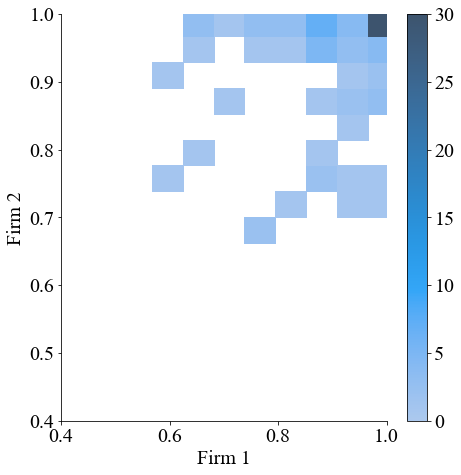

In [29]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
optimality = pd.DataFrame({'Firm 1': optimality_0, 'Firm 2': optimality_1})
sns.displot(optimality, x="Firm 1", y="Firm 2", cbar=True, height=7, aspect=1)
plt.xlim(0.4, 1)
plt.ylim(0.4, 1)

# Empirical Convergence

In [30]:
def Qlearn_Qhistory(epsilon_start, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length):
    # This function saves history of Q-matrix for all t
    # This is used to test empirical convergence of the algorithm
    epsilon = epsilon_start
    
    # initialize Q-tables
    Q0 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q1 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q = [Q0, Q1]
    Q_history = [0] * len_episodes
    
    # lists for saving history of profit
    pro0 = [0] * len_episodes
    pro1 = [0] * len_episodes
    pro = [pro0, pro1]
    
    # initialize the action/state set
    actions_prices= 1 / nprices*np.linspace(0, nprices, nprices)
    actions_locations= 1 / nlocations*np.linspace(0, nlocations, nlocations)
    actions = cartesian_product(actions_prices, actions_locations)

    for n in range(num_episodes): # simulate n epsiodes
        
        # itialize history with randomly chosen prices and locations
        #random.seed(2023)
        history = [deque(actions[random.sample(range(nprices*nlocations), 2)], maxlen=memory_length) for i in range(2)]
        for t in tqdm(range(2, len_episodes)): # iterate through time-steps within an episode
            
            if t % 2 == 0:
                act_agent = 0; inact_agent = 1
            else:
                act_agent = 1; inact_agent = 0
                
            # action number of act_agent at t-2
            a_act_2_number = find_action_number(actions, history[act_agent][-2][0], history[act_agent][-2][1])
            # action number of inact_agent at t-2
            a_inact_2_number = find_action_number(actions, history[inact_agent][-2][0], history[inact_agent][-2][1])
            # action number of inact_agent at t-1
            a_inact_1_number = find_action_number(actions, history[inact_agent][-1][0], history[inact_agent][-1][1])
            
            # profit of act_agent at t-2
            profit2=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-2][0], history[inact_agent][-2][1], actions_locations)
            # profit of act_agent at t-1
            profit1=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            
            # update Q-tables
            Q[act_agent][a_act_2_number][a_inact_2_number] = (1-alpha)*(Q[act_agent][a_act_2_number][a_inact_2_number]) + alpha*(profit2 + delta*profit1 + (delta**2)* np.max(Q[act_agent][:, a_inact_1_number]))
            
            # choose epsilon greedy action
            #np.random.seed(t)
            if np.random.rand()<=epsilon:
                history[act_agent].append(actions[random.randrange(nprices*nlocations)])
            else:
                history[act_agent].append(actions[np.argmax(Q[act_agent][:, a_inact_1_number])])
            history[inact_agent].append(history[inact_agent][-1])
            
            # saving profits
            pro[act_agent][t]=reward(history[act_agent][-1][0], history[act_agent][-1][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            pro[inact_agent][t]=reward(history[inact_agent][-1][0], history[inact_agent][-1][1], history[act_agent][-1][0], history[act_agent][-1][1], actions_locations)
            
            # decay epsilon 
            if t % 2 == 1 and epsilon>epsilon_min:
                epsilon*= epsilon_decay
                
            Q_history[t] = Q
        
        # save results
        now = datetime.now()
        file_name=now.strftime("%Y_%m_%d_%H_%M") + "_" + str(epsilon_start) + "_" + str(epsilon_decay) + "_" + str( epsilon_min) + "_" + str(alpha) + "_" + str(delta) + "_" + str(nprices) + "_" + str(nlocations) + "_" + str(len_episodes) + "_" + str(num_episodes) + "_" + str(memory_length)
        with open(file_name, 'wb') as f:
            pickle.dump([Q_history, history, pro], f)
    return Q_history, history, pro

In [ ]:
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.01
alpha = 0.3
delta = 0.95
nprices = 5
nlocations = 6
len_episodes = 2000000
num_episodes = 1
memory_length = 2000000
for i in range(1):
    Qlearn_Qhistory(epsilon, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length)
    print(f"{i}th simulation complete.")

In [34]:
# load simulation data generated from Qlearn_Qhistory function
with open(os.getcwd()+"\\simulation_data\\2023_06_13_23_06_1_0.9999_0.01_0.3_0.95_5_6_2000000_1_2000000", 'rb') as f:
    data = pickle.load(f)
    for i in [0, 1]: # iterate over agent 0, 1
        for s in range(30): #iterage over all the states
            first_result = np.argmax(data[0][1900000][i][:, s])
            same_result = True
            for t in range(1900001, 1999999): #iterage over the last 100,000 time steps
                current_result = np.argmax(data[0][t][i][:, s])
                if current_result != first_result:
                    print("Q-matrix does not converge.")
                    break
    print("Q-matrix converges")

Q-matrix converges


# Comparative Statistics

## Different Discount Factors

In [35]:
def Qlearn_different_delta(epsilon_start, epsilon_decay, epsilon_min, alpha, delta0, delta1, nprices, nlocations, len_episodes, num_episodes, memory_length):
    # This function simulates sequential Q-learning with different delta for each firm
    
    epsilon = epsilon_start
    delta = [delta0, delta1]
    
    # initialize Q-tables
    Q0 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q1 = np.zeros((nprices*nlocations, nprices*nlocations))
    Q = [Q0, Q1]
    
    # lists for saving history of profit
    pro0 = [0] * len_episodes
    pro1 = [0] * len_episodes
    pro = [pro0, pro1]
    
    # initialize the action/state set
    actions_prices= 1 / nprices*np.linspace(0, nprices, nprices)
    actions_locations= 1 / nlocations*np.linspace(0, nlocations, nlocations)
    actions = cartesian_product(actions_prices, actions_locations)

    for n in range(num_episodes): # simulate n epsiodes
        
        # itialize history with randomly chosen prices and locations
        #random.seed(2023)
        history = [deque(actions[random.sample(range(nprices*nlocations), 2)], maxlen=memory_length) for i in range(2)]
        for t in tqdm(range(2, len_episodes)): # iterate through time-steps within an episode
            
            if t % 2 == 0:
                act_agent = 0; inact_agent = 1
            else:
                act_agent = 1; inact_agent = 0
                
            # action number of act_agent at t-2
            a_act_2_number = find_action_number(actions, history[act_agent][-2][0], history[act_agent][-2][1])
            # action number of inact_agent at t-2
            a_inact_2_number = find_action_number(actions, history[inact_agent][-2][0], history[inact_agent][-2][1])
            # action number of inact_agent at t-1
            a_inact_1_number = find_action_number(actions, history[inact_agent][-1][0], history[inact_agent][-1][1])
            
            # profit of act_agent at t-2
            profit2=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-2][0], history[inact_agent][-2][1], actions_locations)
            # profit of act_agent at t-1
            profit1=reward(history[act_agent][-2][0], history[act_agent][-2][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            
            # update Q-tables
            Q[act_agent][a_act_2_number][a_inact_2_number] = (1-alpha)*(Q[act_agent][a_act_2_number][a_inact_2_number]) + alpha*(profit2 + delta[act_agent]*profit1 + (delta[act_agent]**2)* np.max(Q[act_agent][:, a_inact_1_number]))
            
            # choose epsilon greedy action
            #np.random.seed(t)
            if np.random.rand()<=epsilon:
                history[act_agent].append(actions[random.randrange(nprices*nlocations)])
            else:
                history[act_agent].append(actions[np.argmax(Q[act_agent][:, a_inact_1_number])])
            history[inact_agent].append(history[inact_agent][-1])
            
            # saving profits
            pro[act_agent][t]=reward(history[act_agent][-1][0], history[act_agent][-1][1], history[inact_agent][-1][0], history[inact_agent][-1][1], actions_locations)
            pro[inact_agent][t]=reward(history[inact_agent][-1][0], history[inact_agent][-1][1], history[act_agent][-1][0], history[act_agent][-1][1], actions_locations)
            
            # decay epsilon 
            if t % 2 == 1 and epsilon>epsilon_min:
                epsilon*= epsilon_decay
        
        # save results
        now = datetime.now()
        file_name=now.strftime("%Y_%m_%d_%H_%M") + "_" + str(epsilon_start) + "_" + str(epsilon_decay) + "_" + str( epsilon_min) + "_" + str(alpha) + "_" + str(delta) + "_" + str(nprices) + "_" + str(nlocations) + "_" + str(len_episodes) + "_" + str(num_episodes) + "_" + str(memory_length)
        with open(file_name, 'wb') as f:
            pickle.dump([Q, history, pro], f)
    return Q, history, pro

In [ ]:
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.01
alpha = 0.3
delta0 = 0.95
delta1 = 0.3
nprices = 5
nlocations = 6
len_episodes = 2000000
num_episodes = 1
memory_length = 2000000
for i in range(100):
    Qlearn_different_delta(epsilon_start, epsilon_decay, epsilon_min, alpha, delta0, delta1, nprices, nlocations, len_episodes, num_episodes, memory_length)
    print(f"{i}th simulation complete.")

In [ ]:
file_list=os.listdir(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_[0.95, 0.3]_5_6_2000000_1_2000000\\")

profitability_different_delta_0 = np.zeros(1995001)
profitability_different_delta_1 = np.zeros(1995001)
for file_name in  tqdm(file_list):
    with open(os.getcwd()+"\\simulation_data\\1_0.9999_0.01_0.3_[0.95, 0.3]_5_6_2000000_1_2000000\\"+file_name, 'rb') as f:
        data = pickle.load(f)
        profitability_different_delta_0 = profitability_different_delta_0 + running_mean(data[2][0], 5000)
        profitability_different_delta_1 = profitability_different_delta_1 + running_mean(data[2][1], 5000)
profitability_different_delta_0 = profitability_different_delta_0 / 100
profitability_different_delta_1 = profitability_different_delta_1 / 100

### Line graph of profits with different discount factors for each firm

<ipython-input-47-fd23ce37b1c8>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


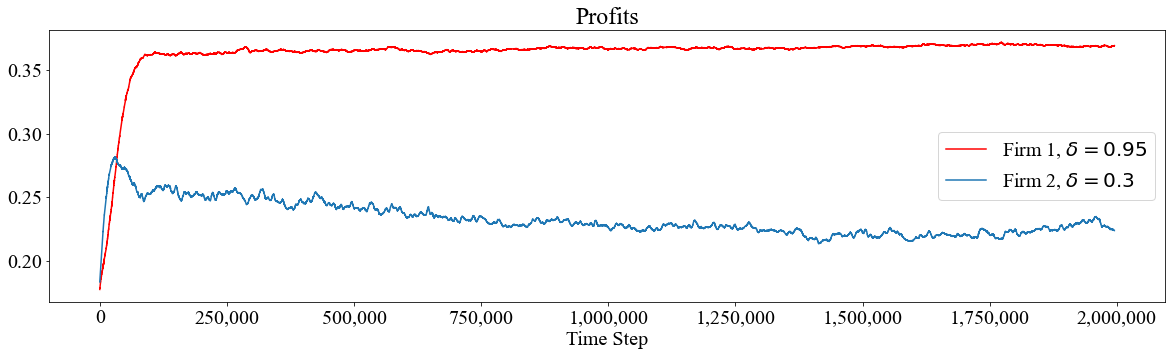

In [47]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(profitability_different_delta_0)), profitability_different_delta_0/12,'r')
plt.plot(range(len(profitability_different_delta_1)), profitability_different_delta_1/12)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.title('Profits')
plt.legend(('Firm 1, $\delta=0.95$','Firm 2, $\delta=0.3$'))

### Comparison of the two cases: baseline setting versus different discount factors

<ipython-input-48-10aca181f982>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


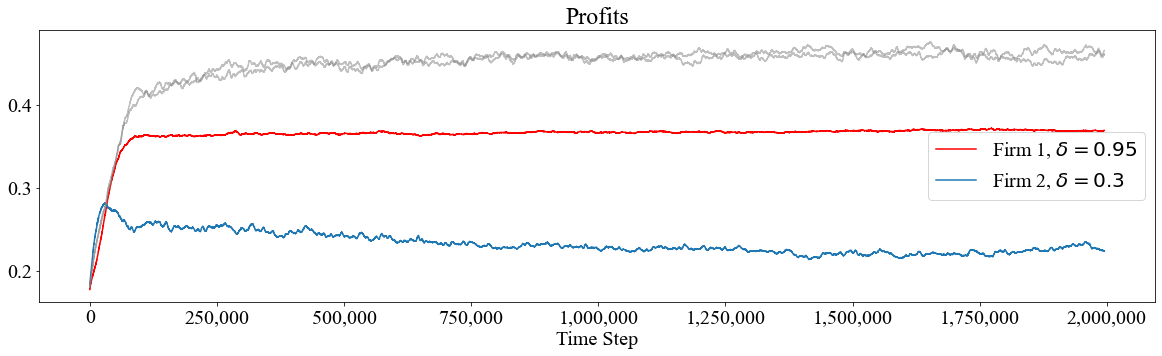

In [48]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(profitability_different_delta_0)), profitability_different_delta_0/12,'r')
plt.plot(range(len(profitability_different_delta_1)), profitability_different_delta_1/12)
plt.plot(range(len(profitability0)), profitability0/12, color="grey", alpha = 0.5)
plt.plot(range(len(profitability1)), profitability1/12, color="grey", alpha = 0.5)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.title('Profits')
plt.legend(('Firm 1, $\delta=0.95$','Firm 2, $\delta=0.3$'))

## Similarity to the Original Hotelling’s Model

In [ ]:
epsilon = 1
epsilon_decay = 0.9999
epsilon_min = 0.05
alpha = 0.3
delta = 0
nprices = 5
nlocations = 5
len_episodes = 5000000
num_episodes = 1
memory_length = 5000000
Qlearn(epsilon, epsilon_decay, epsilon_min, alpha, delta, nprices, nlocations, len_episodes, num_episodes, memory_length)

### Price: line graph for two firms from one simulation

In [39]:
with open(os.getcwd()+"\\simulation_data\\2023_06_29_00_34_1_0.9999_0.01_0.3_0_5_5_2000000_1_2000000", 'rb') as f:
    data = pickle.load(f)

<ipython-input-40-4b6fbaa30d5c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


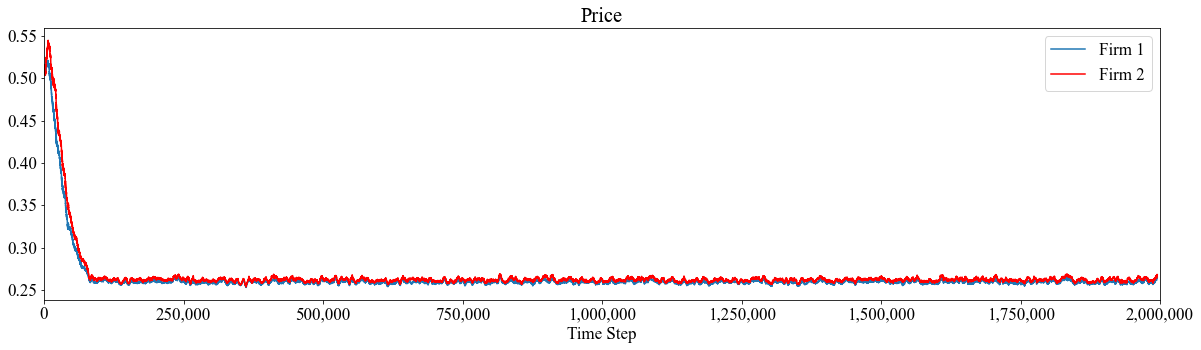

In [40]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 17})
plt.figure(figsize=(20, 5))
plt.plot(range(len(running_mean([arr[0] for arr in data[1][0]], 5000))), running_mean([arr[0] for arr in data[1][0]], 5000))
plt.plot(range(len(running_mean([arr[0] for arr in data[1][1]], 5000))), running_mean([arr[0] for arr in data[1][1]], 5000),'r')
plt.xlim((0, 2000000))
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Price')
plt.legend(('Firm 1','Firm 2'))

### Location: line graph for two firms from one simulation

<ipython-input-41-d62c4a67eb07>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


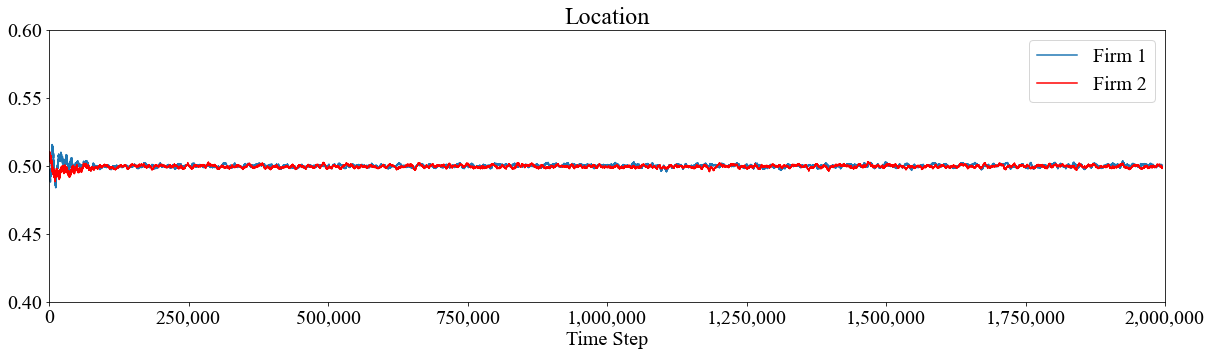

In [41]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 5))
plt.plot(range(len(running_mean(np.array([arr[1] for arr in data[1][0]]), 5000))), running_mean(np.array([arr[1] for arr in data[1][0]]), 5000))
plt.plot(range(len(running_mean(np.array([arr[1] for arr in data[1][1]]), 5000))), running_mean(np.array([arr[1] for arr in data[1][1]]), 5000),'r')
plt.xlim((0, 2000000))
plt.ylim((0.4, 0.6))
plt.axhline(1.0, color='lightgray', linestyle='--', linewidth=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.xlabel('Time Step')
plt.ylabel('')
plt.title('Location')
plt.legend(('Firm 1','Firm 2'))